In [32]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
from shapely.geometry import Polygon
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
cwd = '/content/drive/MyDrive/SunflowerStarRebirth/StarChamber'

In [35]:
os.chdir(cwd)

In [36]:
data_directory = 'data/cold_box_flips'
os.path.exists(data_directory)

True

data/cold_box_flips/R3_W1_12C
	i12
	  0-12_14_23-14_38_49-i12.csv


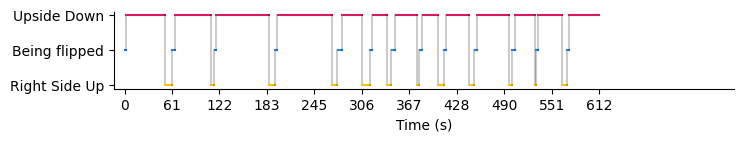

	i1
	  0-12_14_23-14_00_42-i1.csv


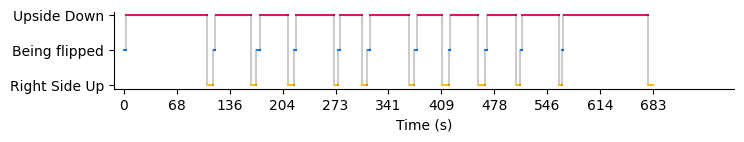

	i10
	  0-12_14_23-14_26_30-i10.csv


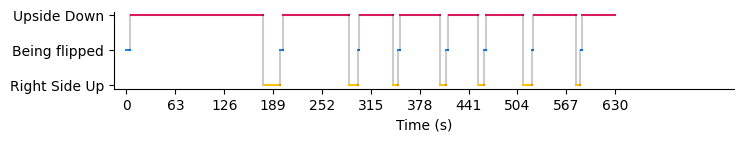

	p4
	  0-12_14_23-13_22_53-p4.csv


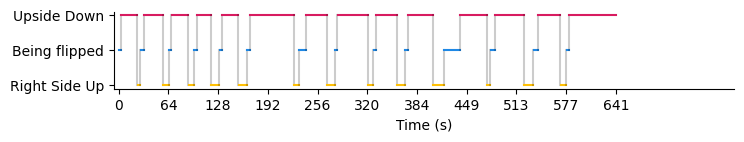

	p3
	  0-12_14_23-13_09_30-p3.csv


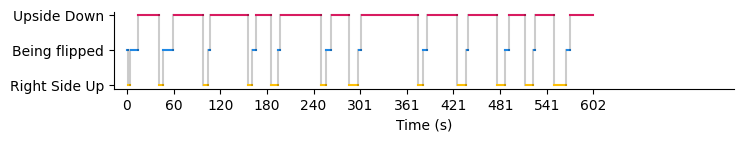

	i9
	  0-12_14_23-14_13_30-i9.csv


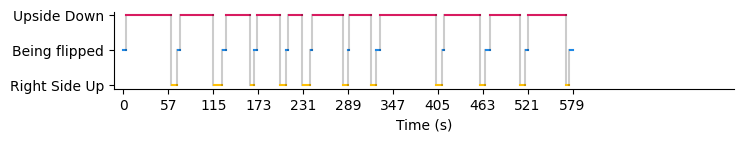

	p7
	  0-12_14_23-13_47_49-p7.csv


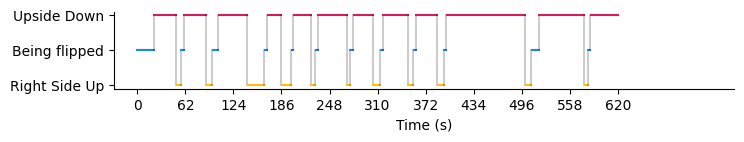

	p5
	  1-12_14_23-13_34_54-p5.csv


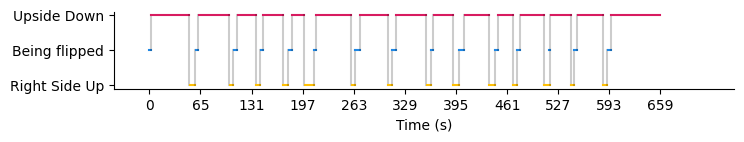

data/cold_box_flips/R2_W2_12C
	p2
	  0-12_10_23-13_34_22-p2.csv


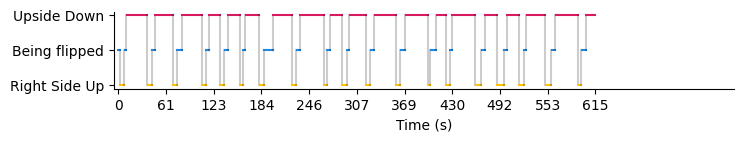

	p11
	  0-12_10_23-13_58_59-p11.csv


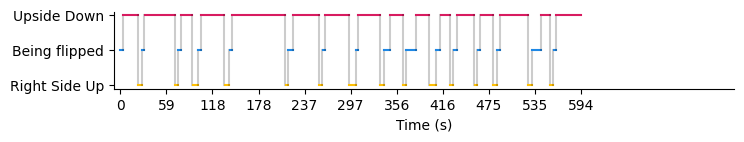

	p1
	  0-12_10_23-13_19_29-p1.csv


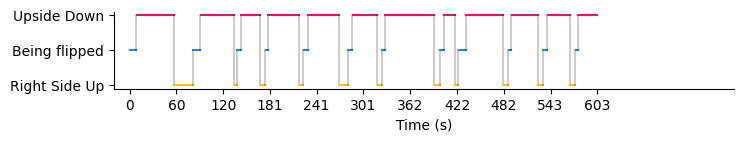

	i4
	  0-12_10_23-12_53_13-i4.csv


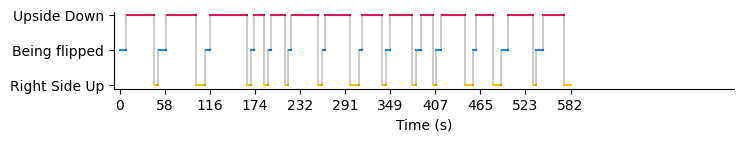

	p8
	  0-12_10_23-13_46_42-p8.csv


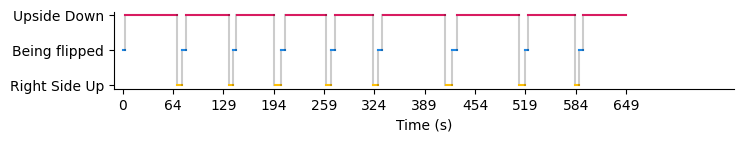

	i2
	  0-12_10_23-12_40_36-i2.csv


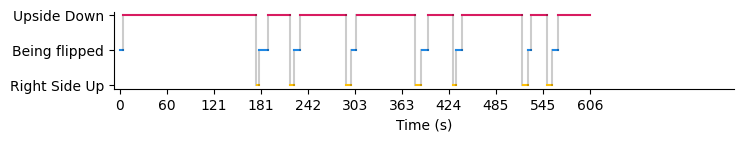

	i6
	  0-12_10_23-13_07_10-i6.csv


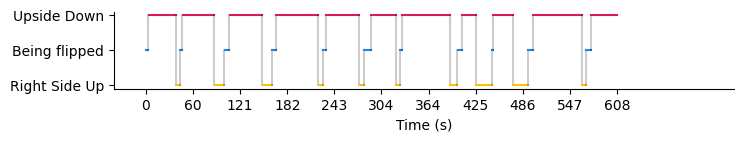

data/cold_box_flips/R2_W1_12C
	i2
	  0-12_04_23-14_02_09-i2.csv


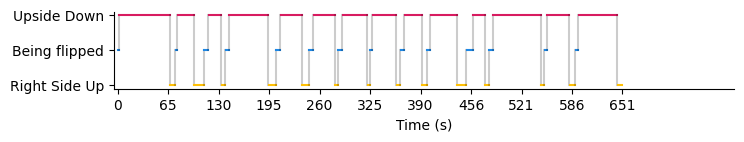

	i6
	  0-12_04_23-14_29_42-i6.csv


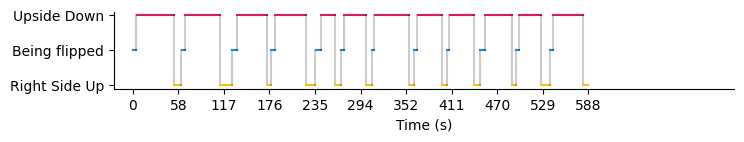

	i4
	  0-12_04_23-14_16_26-i4.csv


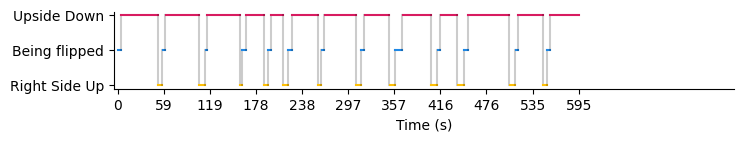

	p11
	  0-12_04_23-15_26_52-p11.csv


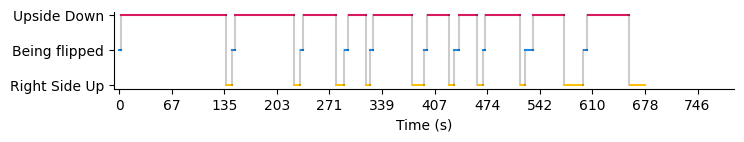

	p2
	  0-12_04_23-14_58_24-p2.csv


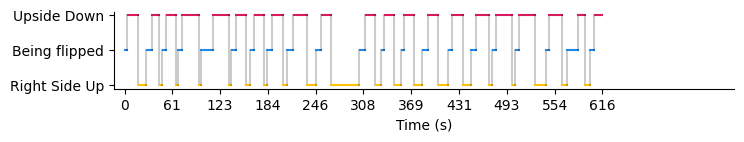

	p8
	  0-12_04_23-15_12_38-p8.csv


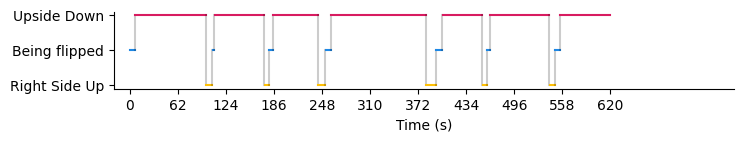

	p1
	  0-12_04_23-14_42_36-p1.csv


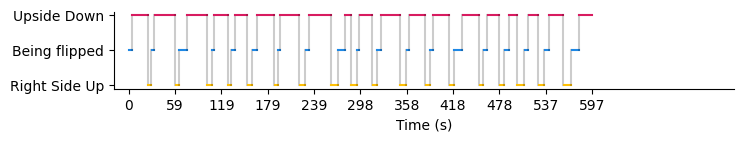

data/cold_box_flips/R1_W2_14-5C
	p12
	  0-11_19_23-12_58_19-p12.csv


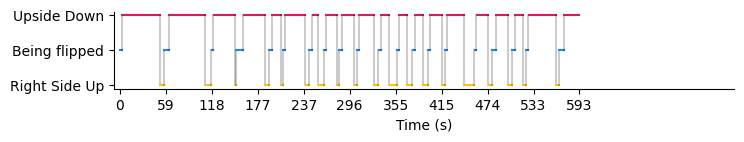

	i8
	  0-11_19_23-13_37_10-i8.csv


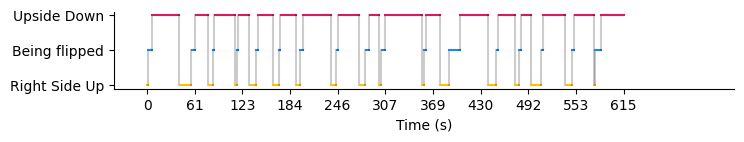

	i3
	  0-11_19_23-13_10_37-i3.csv


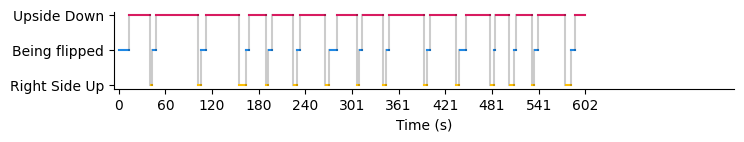

	i7
	  0-11_19_23-13_22_44-i7.csv


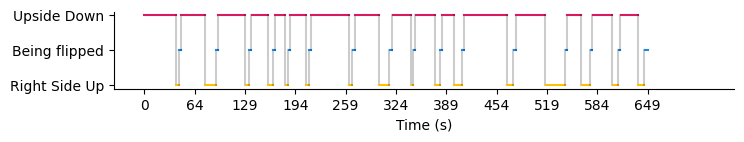

	p10
	  0-11_19_23-12_45_47-p10.csv


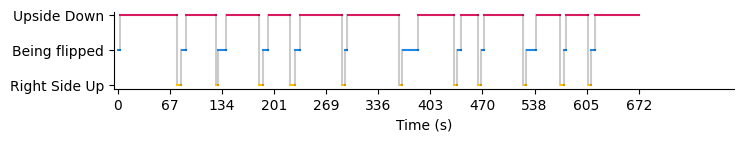

	i11
	  0-11_19_23-13_49_28-i11.csv


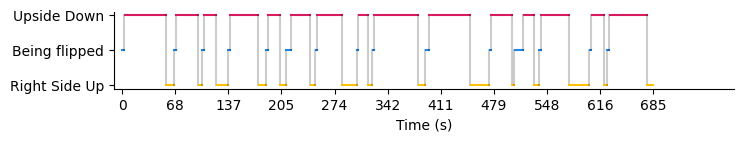

	p6
	  0-11_19_23-12_21_23-p6.csv


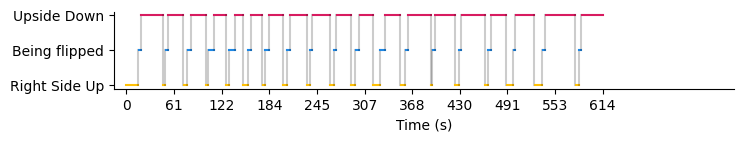

	p9
	  0-11_19_23-12_33_38-p9.csv


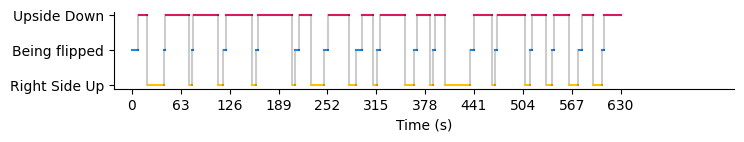

data/cold_box_flips/R3_W2_17C
	i9
	  0-12_20_23-13_12_26-i9.csv


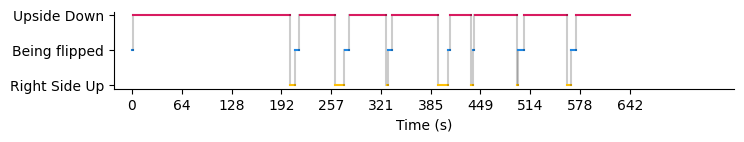

	i10
	  0-12_20_23-13_35_19-i10.csv


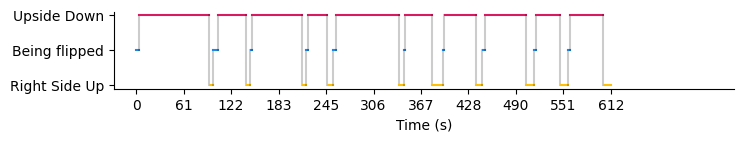

	p3
	  0-12_20_23-12_11_08-p3.csv


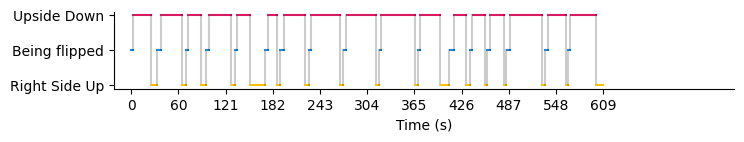

	i1
	  0-12_20_23-13_00_13-i1.csv


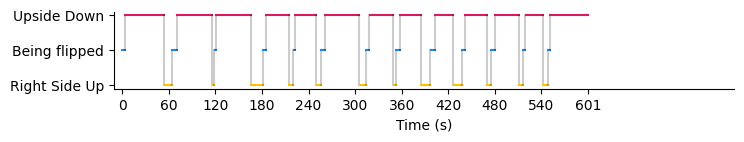

	i12
	  0-12_20_23-13_47_23-i12.csv


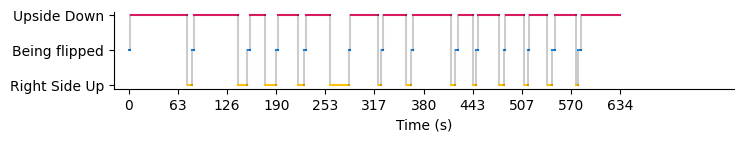

	p5
	  0-12_20_23-12_35_44-p5.csv


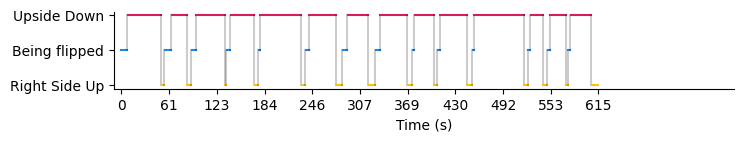

	p4
	  0-12_20_23-12_23_39-p4.csv


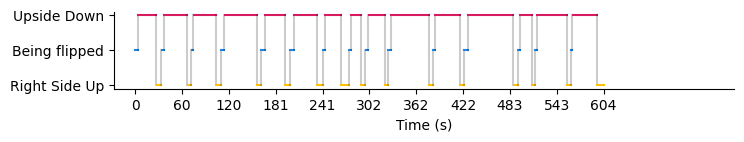

	p7
	  0-12_20_23-12_48_06-p7.csv


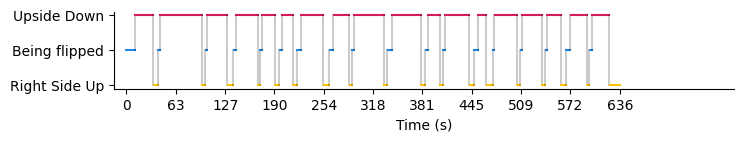

data/cold_box_flips/R1_W1_12C
	i11
	  0-11_12_23-14_51_47-i11.csv


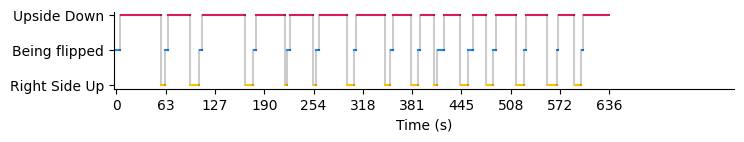

	i8
	  0-11_12_23-14_36_34-i8.csv


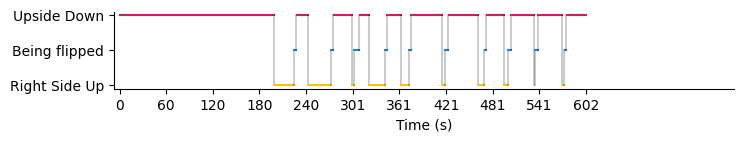

	i3
	  0-11_12_23-14_10_13-i3.csv


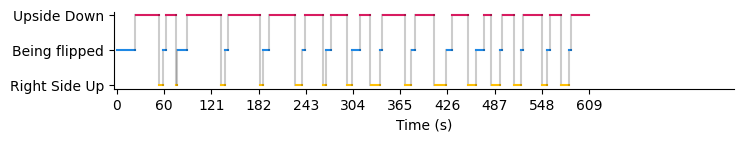

	p9
	  0-11_12_23-13_26_32-p9.csv


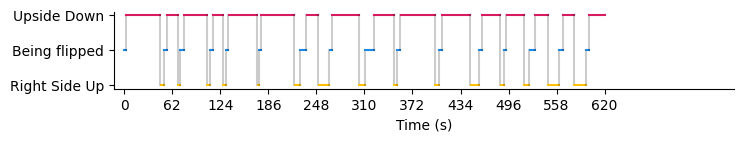

	p12
	  0-11_12_23-13_56_34-p12.csv


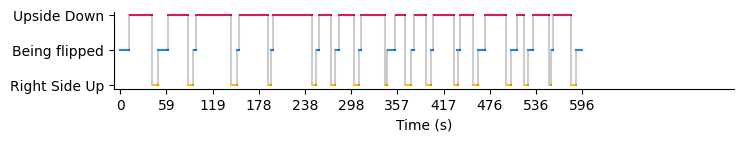

	p6
	  0-11_12_23-13_11_25-p6.csv


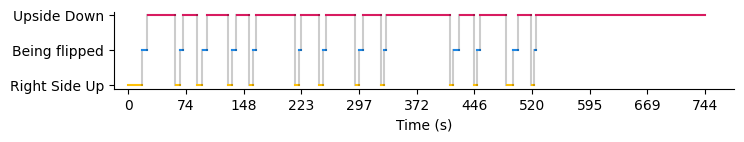

In [37]:
def add_to_new_items(new_starts, new_ends, new_types, sf0, ef0, t0):
  new_starts.append(sf0)
  new_ends.append(ef0)
  new_types.append(t0)
  return new_starts, new_ends, new_types

def insert_merge_index(midx, new_starts, new_ends, new_types, sf, ef, t, debug):
  if debug:
    print(new_starts[midx[0]:midx[1]+1],
          new_ends[midx[0]:midx[1]+1],
          new_types[midx[0]:midx[1]+1])
  ns0, ns1 = new_starts[:midx[0]], new_starts[midx[1]+1:]
  ne0, ne1 = new_ends[:midx[0]], new_ends[midx[1]+1:]
  nt0, nt1 = new_types[:midx[0]], new_types[midx[1]+1:]

  ns0.append(sf)
  ne0.append(ef)
  nt0.append(t)

  new_starts = ns0 + ns1
  new_ends = ne0 + ne1
  new_types = nt0 + nt1

  return new_starts, new_ends, new_types

def merge_rows(new_starts, new_ends, new_types, debug, iterations=5):
  if debug:
    print('merging rows')
  for iter in range(0,iterations):
    if debug:
      print('iter', iter)
    j = 0
    merge_indexes = []
    for t0, t1 in zip(new_types[:-1], new_types[1:]):
      if t0 == t1:
        if debug:
          print('\t',f'{j}-{t0}, {j+1}-{t1}')
        merge_indexes.append([j, j+1])
        break
      j += 1
    if debug:
      print('\t',merge_indexes)

    for midx in merge_indexes:
      sf = new_starts[midx[0]]
      ef = new_ends[midx[1]]
      t = new_types[midx[0]]
      if debug:
        print(midx, '-[', new_starts[midx[0]], new_ends[midx[0]], new_types[midx[0]],
              '-',new_starts[midx[1]], new_ends[midx[1]], new_types[midx[1]], ']-to',
              sf, ef, t)
      new_starts, new_ends, new_types = insert_merge_index(midx,
                                                           new_starts,
                                                           new_ends,
                                                           new_types,
                                                           sf, ef, t,
                                                           debug)
  return new_starts, new_ends, new_types

def plot_df(df, path_fig, type_numeric_code, yticks, ylabs):
  starts = df['start_frame']
  stops = df['end_frame']
  types = df['type']
  types_numeric = [type_numeric_code[s] for s in types]

  types_color = [color_key_type[s] for s in types]
  fig, ax = plt.subplots(1,1,figsize=(8,1))

  n = 0
  for s, e, tn, tc in zip(starts, stops, types_numeric, types_color):
    ax.plot([s,e], [tn, tn], color=tc)
    if n < len(starts)-1:
      ax.plot([e,e], [tn, types_numeric[n+1]], color='black',alpha=0.2)
    n += 1

  xmin = min(starts)
  xmax = max(stops)

  xticks = np.arange(xmin, xmax+(xmax-xmin)/10, (xmax-xmin)/10)
  xlabs = xticks/fps
  xlabs = xlabs - min(xlabs)
  xlabs = xlabs.astype(int)
  ax.set_xticks(xticks)
  ax.set_xticklabels(xlabs)
  ax.set_xlim(0,1600)

  ax.set_yticks(yticks)
  ax.set_yticklabels(ylabs)

  ax.set_xlabel('Time (s)')

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  if path_fig != None:
    fig.savefig(path_fig, dpi=300, bbox_inches='tight')

  plt.show(fig)
  plt.close()

## we are doing the slow by easy to understand code of concat to dataframe
## note using concat incurs quadratic slowing, luckily, our dataframe is TINY
data = pd.DataFrame(columns=['video_path',
                             'time_order',
                             'id',
                             'run',
                             'week',
                             'temp_c',
                             'start_frame',
                             'end_frame',
                             'time_s',
                             'flip_order',
                             'type'])

color_key_type = {'Right Side Up':'#FFC107',
                  'Being flipped':'#1E88E5',
                  'Upside Down':'#D81B60'}
type_numeric_code = {'Right Side Up':0,
                     'Being flipped':1,
                     'Upside Down':2}
yticks = [type_numeric_code[key] for key in type_numeric_code.keys()]
ylabs = [key for key in type_numeric_code.keys()]

data_sub_directories = glob.glob(os.path.join(data_directory, 'R*'))

show = True
savePlot = False
showN = 50
debug = False
short = False

fps = 2
n = 0
for sub_dir in data_sub_directories[:]:
  print(sub_dir)
  for dir in os.listdir(sub_dir):
    dir = os.path.join(sub_dir, dir)
    if os.path.isdir(dir):
      print(f'\t{os.path.basename(dir)}')
      for f in os.listdir(dir):
        if '.csv' in f:
          print(f'\t  {f}')
          df = pd.read_csv(os.path.join(dir,f))

          new_starts = []
          new_ends = []
          new_types = []
          for row0, row1 in zip(df.iloc[:-1].iterrows(),
                                df.iloc[1:].iterrows()):
            row0, row1 = row0[1].copy(), row1[1].copy()
            sf0, ef0, t0 = row0['start_frame'], row0['end_frame'], row0['type']
            sf1, ef1, t1 = row1['start_frame'], row1['end_frame'], row1['type']

            if ef0 == sf1-1:
              if debug:
                print('condition (ef0 == sf1-1)', sf0, ef0, t0, ' - ', sf1, ef1, t1)
              new_starts, new_ends, new_types = add_to_new_items(new_starts,
                                                                 new_ends,
                                                                 new_types,
                                                                 sf0, ef0, t0)
              if debug:
                print('\t', (sf0, ef0, t0))
            elif ef0 < sf1-1:
              if debug:
                print('condition (ef0 < sf1-1)', sf0, ef0, t0, ' - ', sf1, ef1, t1)
              ef0 = sf1-1
              if debug:
                print('\t','ef0 = ', ef0)
              new_starts, new_ends, new_types = add_to_new_items(new_starts,
                                                                 new_ends,
                                                                 new_types,
                                                                 sf0, ef0, t0)
              if debug:
                print('\t', (sf0, ef0, t0))

          if show == True and n < showN and debug:
            new_df = pd.DataFrame(list(zip(new_starts,
                                         new_ends,
                                         new_types)),
                                columns=['start_frame',
                                         'end_frame',
                                         'type'])
            plot_df(new_df, None, type_numeric_code, yticks, ylabs)

          new_starts, new_ends, new_types = merge_rows(new_starts,
                                                       new_ends,
                                                       new_types,
                                                       debug)

          time_order = [s for s in range(0,len(new_starts))]
          m = 0
          flip_order = []
          for cat, tord in zip(new_types, time_order):
            if cat == 'Upside Down':
              flip_order.append(m)
              m += 1
            else:
              flip_order.append(None)

          video_path = [glob.glob(os.path.join(dir, '*.mp4'))[0]]*len(new_starts)
          id = os.path.basename(dir)
          run, week, temp = os.path.basename(sub_dir).split('_')
          temp = temp.split('C')[0]
          temp = temp.replace('-','.')
          temp = float(temp)
          if debug:
            print(id, run, week, temp)
          id = [id]*len(new_starts)
          run = [run]*len(new_starts)
          week = [week]*len(new_starts)
          temp = [temp]*len(new_starts)

          time = [(ef-sf)/fps for sf, ef in zip(new_starts, new_ends)]

          new_df = pd.DataFrame(list(zip(video_path,
                                         time_order,
                                         id,
                                         run,
                                         week,
                                         temp,
                                         new_starts,
                                         new_ends,
                                         time,
                                         flip_order,
                                         new_types)),
                                columns=['video_path',
                                         'time_order',
                                         'id',
                                         'run',
                                         'week',
                                         'temp_c',
                                         'start_frame',
                                         'end_frame',
                                         'time_s',
                                         'flip_order',
                                         'type'])
          new_df = new_df.iloc[1:-1]

          data = pd.concat([data, new_df])

          if show == True and n < showN:
            if debug:
              plot_df(df, None, type_numeric_code, yticks, ylabs)
            if savePlot:
              path_fig = os.path.join(dir,f).split('.csv')[0] + '_timeseries.png'
            else:
              path_fig = None
            plot_df(new_df, path_fig, type_numeric_code, yticks, ylabs)

          n+=1
          if short:
            break
    if short:
      break
  if short:
    break


In [38]:
## fixing a coding error in the data log ##
## R2 W1 and W2 p11 is actually i5
id = data['id'].tolist()
id = [s if s != 'p11' else 'i5' for s in id]
data['id'] = id

In [39]:
cohort = [s[0] for s in data['id']]
data.insert(2, 'cohort', cohort)

In [40]:
path_data = os.path.join(data_directory, 'flipping_data.csv')
path_data, os.path.exists(path_data)

('data/cold_box_flips/flipping_data.csv', True)

In [41]:
meta = pd.read_csv(os.path.join(data_directory, 'cold_box_flips_flipping_meta.csv'))
id = meta['animal_id'].tolist()
id = [s if s != 'p11' else 'i5' for s in id]
id = [s.replace(' ', '') for s in id]
meta['animal_id'] = id
meta.rename(columns={'animal_id': 'id'}, inplace=True)
run = [s.split(' ')[0] for s in meta['trial']]
week = [s.split(' ')[1] for s in meta['trial']]
meta['trial'] = run
meta.rename(columns={'trial': 'run'}, inplace=True)
meta.insert(1, 'week', week)
meta.rename(columns={'eating_before (y/n/m)': 'eating_before'}, inplace=True)
meta.rename(columns={'sleeping (y/n/m)': 'sleeping_before'}, inplace=True)
cohort = [s[0] for s in meta['id']]
meta.insert(2, 'cohort', cohort)
meta

,run,week,cohort,id,eating_before,sleeping_before,date
0,R1,W1,p,p6,m,n,11/12/2023
1,R1,W1,p,p9,y,n,11/12/2023
2,R1,W1,p,p10,n,y,11/12/2023
3,R1,W1,p,p12,n,n,11/12/2023
4,R1,W1,i,i3,n,m,11/12/2023
5,R1,W1,i,i7,n,m,11/12/2023
6,R1,W1,i,i8,n,m,11/12/2023
7,R1,W1,i,i11,y,n,11/12/2023
8,R1,W2,p,p6,n,m,11/19/2023
9,R1,W2,p,p9,n,n,11/19/2023


In [42]:
def best_fit_circle(x, y):
  """
  Find the center and radius of the best fit circle for given coordinates.
  """
  coordinates = np.vstack((x,y)).T

  # Initial guess for the circle center (x0, y0) and radius r
  x0 = np.mean(coordinates[:, 0])
  y0 = np.mean(coordinates[:, 1])
  r_initial = np.sqrt((coordinates[:, 0] - x0)**2 + (coordinates[:, 1] - y0)**2).max()

  # Objective function: minimize the radius
  def objective(params):
      x_c, y_c, r = params
      return r

  # Constraint: all points must be inside the circle
  def constraint(params):
      x_c, y_c, r = params
      return r**2 - ((coordinates[:, 0] - x_c)**2 + (coordinates[:, 1] - y_c)**2)

  # Optimization
  result = minimize(objective, [x0, y0, r_initial], constraints={'type': 'ineq', 'fun': constraint})

  if result.success:
      x_c, y_c, r = result.x
      return (x_c, y_c, r), result.success
  else:
      return None, result.success

verbose = False
show = True

contract_window_by_ratio = 0.1

areas = []
radii = []
for row in meta.iloc[:].iterrows():
  row = row[1]
  id = row['id']
  week = row['week']
  tmp = data[(data['id'] == id) & (data['week'] == week) & (data['type'] == 'Right Side Up')]
  if tmp.shape[0] < 1:
    areas.append(None)
    radii.append(None)
  else:
    tmp.reset_index(drop=True, inplace=True)
    index_max_time = tmp['time_s'].idxmax()
    tmp = tmp.iloc[index_max_time]

    sf, ef = tmp['start_frame'], tmp['end_frame']
    d = ef-sf
    contract_window_by = d*contract_window_by_ratio
    sf = int(sf + contract_window_by)
    ef = int(ef - contract_window_by)

    video_path = tmp['video_path']
    video_dir = os.path.dirname(video_path)
    path_pickle = 'rawTracks_yolov8_' + os.path.basename(video_path).split('.mp4')[0] + '.pickle'
    path_pickle = os.path.join(video_dir, path_pickle)

    if verbose:
      print(video_dir)
      for f in os.listdir(video_dir):
        print(f'\t{f}')
      print()

    if os.path.exists(path_pickle) != True:
      print(f'{path_pickle} - tracking does not exist!')
      break
    else:
      if verbose:
        print(f'\t{path_pickle} - tracking exists! opening it')
      df = pd.read_pickle(path_pickle)
      index_max_area = 0
      max_area = 0
      if show:
        fig, axs = plt.subplots(1,3,figsize=(9,3))
        ax = axs[1]
      for k in range(sf, ef):
        df_tmp = df.iloc[k]
        if df_tmp['masks_xy'] != None:
          pgon = Polygon(df_tmp['masks_xy'][0])
          area_polygon = pgon.area
          if area_polygon > max_area:
            index_max_area = k
            max_area = area_polygon
        if show:
          ax.plot(*pgon.exterior.xy, linewidth=1, alpha=0.1, color='black')
      if show:
        df_tmp = df.iloc[index_max_area]
        pgon = Polygon(df_tmp['masks_xy'][0])
        ax.plot(*pgon.exterior.xy, linewidth=2, alpha=1, color='red')
        ax.set_aspect('equal')

      df = df.iloc[index_max_area]
      frame_id = df['ids']
      if len(frame_id) != 1:
        print('wrong number of tracking ids')
        break
      frame_id = frame_id[0]
      pgon = Polygon(df['masks_xy'][0])

      bounds = pgon.bounds
      min_x, min_y, max_x, max_y = bounds[0], bounds[1], bounds[2], bounds[3]

      x,y = pgon.exterior.xy
      x,y = np.array(x), np.array(y)
      area = pgon.area
      areas.append(area)

      circle_params, success = best_fit_circle(x,y)
      x_c, y_c, r = circle_params
      radii.append(r)

      cap = cv2.VideoCapture(video_path)
      w,h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

      cap.set(cv2.CAP_PROP_POS_FRAMES, index_max_area)
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      cap.release()

      cropped_frame = frame[int(min_y) : int(max_y), int(min_x) : int(max_x)]

      shifted_x, shifted_y = x - min_x, y - min_y

      if show:

        ax = axs[0]
        ax.imshow(frame)
        ax.plot(x,y, linewidth=1,
                alpha=1, color='red')
        circle = plt.Circle((x_c, y_c), r, color='red', fill=False)
        ax.add_artist(circle)
        ax.set_aspect('equal')

        ax = axs[2]
        ax.imshow(cropped_frame)
        ax.plot(shifted_x, shifted_y, linewidth=1,
                alpha=1, color='red')
        circle = plt.Circle((x_c - min_x, y_c - min_y), r, color='red', fill=False)
        ax.add_artist(circle)
        ax.set_aspect('equal')

        fig.tight_layout()

        plt.show(fig)
        plt.close(fig)

if meta.shape[0] == len(areas):
  meta['area'] = areas
  meta['radius'] = radii
else:
  print('wrong number of areas')


Output hidden; open in https://colab.research.google.com to view.

In [43]:
path_meta = os.path.join(data_directory, 'CLEAN_cold_box_flips_flipping_meta.csv')
meta.to_csv(path_meta, index=False)
meta

,run,week,cohort,id,eating_before,sleeping_before,date,area,radius
0,R1,W1,p,p6,m,n,11/12/2023,13618.946075,94.202299
1,R1,W1,p,p9,y,n,11/12/2023,11971.778870,90.145847
2,R1,W1,p,p10,n,y,11/12/2023,NaN,NaN
3,R1,W1,p,p12,n,n,11/12/2023,24971.828461,126.729850
4,R1,W1,i,i3,n,m,11/12/2023,25452.117920,132.826348
5,R1,W1,i,i7,n,m,11/12/2023,NaN,NaN
6,R1,W1,i,i8,n,m,11/12/2023,23385.906219,124.271877
7,R1,W1,i,i11,y,n,11/12/2023,18096.275330,108.450074
8,R1,W2,p,p6,n,m,11/19/2023,16229.915619,94.796303
9,R1,W2,p,p9,n,n,11/19/2023,14237.842560,99.298641


In [44]:
data = pd.merge(data,
                meta[['id', 'week', 'eating_before', 'sleeping_before', 'area', 'radius']],
                on=['id', 'week'], how='left')
data.reset_index(drop=True)

,video_path,time_order,cohort,id,run,week,temp_c,start_frame,end_frame,time_s,flip_order,type,eating_before,sleeping_before,area,radius
0,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,1,i,i12,R3,W1,12.0,27,30,1.5,NaN,Being flipped,n,m,49047.546387,176.533330
1,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,2,i,i12,R3,W1,12.0,31,131,50.0,0.0,Upside Down,n,m,49047.546387,176.533330
2,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,3,i,i12,R3,W1,12.0,132,149,8.5,NaN,Right Side Up,n,m,49047.546387,176.533330
3,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,4,i,i12,R3,W1,12.0,150,157,3.5,NaN,Being flipped,n,m,49047.546387,176.533330
4,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,5,i,i12,R3,W1,12.0,158,249,45.5,1.0,Upside Down,n,m,49047.546387,176.533330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,35,p,p6,R1,W1,12.0,1030,1042,6.0,NaN,Being flipped,m,n,13618.946075,94.202299
1798,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,36,p,p6,R1,W1,12.0,1043,1077,17.0,12.0,Upside Down,m,n,13618.946075,94.202299
1799,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,37,p,p6,R1,W1,12.0,1078,1084,3.0,NaN,Right Side Up,m,n,13618.946075,94.202299
1800,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,38,p,p6,R1,W1,12.0,1085,1089,2.0,NaN,Being flipped,m,n,13618.946075,94.202299


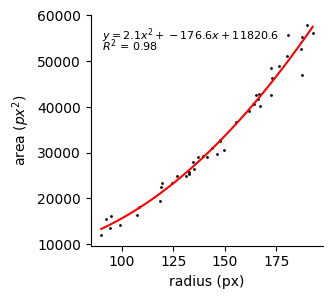

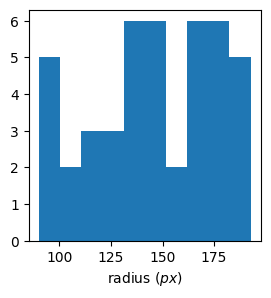

In [85]:
fig, ax = plt.subplots(1,1,figsize=(3,3))

radius = np.array(meta['radius'])
area = np.array(meta['area'])
## drop None
radius = radius[~np.isnan(radius)]
area = area[~np.isnan(area)]

ax.scatter(radius, area,
           s=1, color='black')
ax.set_xlabel('radius (px)')
ax.set_ylabel('area ($px^2$)')

# Fitting a second order polynomial to the data
coefficients = np.polyfit(radius,
                          area, 2)
polynomial = np.poly1d(coefficients)

# Calculate the mean of the observed values (area)
mean_area = np.mean(area)

# Calculate Total Sum of Squares (SST)
SST = np.sum((area - mean_area)**2)

# Calculate the values predicted by the polynomial model
predicted_area = polynomial(radius)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((area - predicted_area)**2)

# Calculate R-squared
R_squared = 1 - (SSR / SST)
R_squared

# Generating values for the fitted curve
x = np.linspace(min(radius),
                max(radius), 100)
y = polynomial(x)

# Plotting the fitted curve
ax.plot(x, y, color='red')

## print text
text = f'$R^2$ = {R_squared:.2f}'
ax.text(0.05, 0.9, text, transform=ax.transAxes,
        fontsize=8, verticalalignment='top')
## get equation
equation = f'$y = {coefficients[0]:.1f}x^2 + {coefficients[1]:.1f}x + {coefficients[2]:.1f}$'
ax.text(0.05, 0.95, equation, transform=ax.transAxes,
        fontsize=8, verticalalignment='top')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show(fig)
plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(3,3))

ax.hist(radius)
ax.set_xlabel('radius ($px$)')

plt.show(fig)
plt.close(fig)

In [45]:
"""
columns = Index(['video_path', 'time_order', 'id', 'run', 'week', 'temp_c',
                 'start_frame', 'end_frame', 'time_s', 'flip_order', 'type'],
          dtype='object')

video_path : String
  path to video

time_order : Int
  time order in which 'type' was observed

id : String
  identity of individual star

run : String
  experiment run (R1, R2, R3)

week : String
  week of experiment run

temp_c : String
  temperature treatment for given run + week

start_frame : Int
  starting frame of type observation, fps = 2

end_frame : Int
  ending frame of type observation, fps = 2

time_s : Float
  Duration of observation for observed type. E.g., Upsided down for 10 seconds

flip_order : Int
  Order in which type 'Upside Down' was observed, if type != 'Upside Down' nan, filter by type == 'Upside Down' before using

type : String
  Observation type 'Right Side Up' or 'Being flipped' or 'Upside Down'

eating_before	: String
  'y' 'm' 'n' based upon our observations of the stars as we transferred them to the dish
  'y' and 'n' are not that subjective. 'm' is subjective

sleeping_before
  'y' 'm' 'n' based upon our observations of the stars as we transferred them to the dish
  very subjective measurement

area : Float
  area of star in pixels

radius : Float
  radius of star in pixels
"""
data

,video_path,time_order,cohort,id,run,week,temp_c,start_frame,end_frame,time_s,flip_order,type,eating_before,sleeping_before,area,radius
0,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,1,i,i12,R3,W1,12.0,27,30,1.5,NaN,Being flipped,n,m,49047.546387,176.533330
1,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,2,i,i12,R3,W1,12.0,31,131,50.0,0.0,Upside Down,n,m,49047.546387,176.533330
2,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,3,i,i12,R3,W1,12.0,132,149,8.5,NaN,Right Side Up,n,m,49047.546387,176.533330
3,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,4,i,i12,R3,W1,12.0,150,157,3.5,NaN,Being flipped,n,m,49047.546387,176.533330
4,data/cold_box_flips/R3_W1_12C/i12/0-12_14_23-1...,5,i,i12,R3,W1,12.0,158,249,45.5,1.0,Upside Down,n,m,49047.546387,176.533330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,35,p,p6,R1,W1,12.0,1030,1042,6.0,NaN,Being flipped,m,n,13618.946075,94.202299
1798,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,36,p,p6,R1,W1,12.0,1043,1077,17.0,12.0,Upside Down,m,n,13618.946075,94.202299
1799,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,37,p,p6,R1,W1,12.0,1078,1084,3.0,NaN,Right Side Up,m,n,13618.946075,94.202299
1800,data/cold_box_flips/R1_W1_12C/p6/0-11_12_23-13...,38,p,p6,R1,W1,12.0,1085,1089,2.0,NaN,Being flipped,m,n,13618.946075,94.202299


In [46]:
data.to_csv(path_data, index=False)

In [47]:
data.columns

Index(['video_path', 'time_order', 'cohort', 'id', 'run', 'week', 'temp_c',
       'start_frame', 'end_frame', 'time_s', 'flip_order', 'type',
       'eating_before', 'sleeping_before', 'area', 'radius'],
      dtype='object')

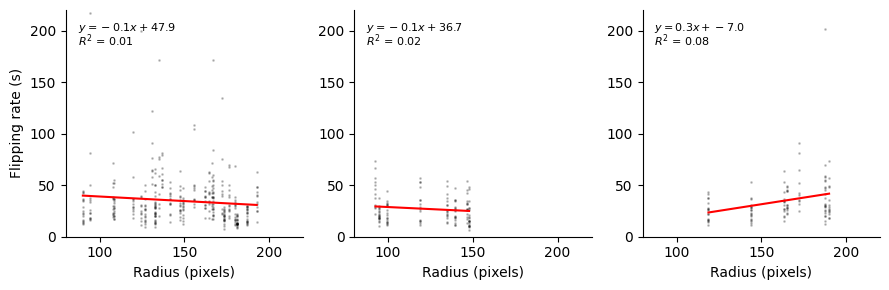

In [82]:

ylims = (0, 220)
xlims = (80, 220)

fig, axs = plt.subplots(1,3,figsize=(9,3))

for i, temp in enumerate([12, 14.5, 17]):
  tmp = data[(data['temp_c'] == temp) & (data['type'] == 'Upside Down')]
  if len(tmp) > 0:
    y = tmp['time_s'].tolist()
    x = tmp['radius'].tolist()

    ax = axs[i]
    ax.scatter(x, y, color='black', s=1, alpha=0.2)

    # Fitting a first order polynomial to the data
    coefficients = np.polyfit(x,
                              y, 1)
    polynomial = np.poly1d(coefficients)


    # Calculate the mean of the observed values
    mean_y = np.mean(y)

    # Calculate Total Sum of Squares (SST)
    SST = np.sum((y - mean_y)**2)

    # Calculate the values predicted by the polynomial model
    predicted_y = polynomial(x)

    # Calculate Residual Sum of Squares (SSR)
    SSR = np.sum((y - predicted_y)**2)

    # Calculate R-squared
    R_squared = 1 - (SSR / SST)
    R_squared

    # Generating values for the fitted curve
    X = np.linspace(min(x),
                    max(x), 100)
    Y = polynomial(X)

    # Plotting the fitted curve
    ax.plot(X, Y, color='red')

    ## print text
    text = f'$R^2$ = {R_squared:.2f}'
    ax.text(0.05, 0.9, text, transform=ax.transAxes,
            fontsize=8, verticalalignment='top')
    ## get equation
    equation = f'$y = {coefficients[0]:.1f}x + {coefficients[1]:.1f}$'
    ax.text(0.05, 0.95, equation, transform=ax.transAxes,
            fontsize=8, verticalalignment='top')

for i, temp in enumerate([12, 14.5, 17]):
  ax = axs[i]
  ax.set_ylim(ylims)
  ax.set_xlim(xlims)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_xlabel('Radius (pixels)')
  if i == 0:
    ax.set_ylabel('Flipping rate (s)')

fig.tight_layout()

plt.show(fig)
plt.close(fig)